# Tutorial seg-y editing using deltaseis

In this tutorial we will load a seg-y file and performs several edits to it before writing the results to a copy of this seg-y file. The operatations we will go through are:
- setting a new record lengths to reduce data volume
- fix navigation of spike or erroneous values if there are any
- perform a coordinate transformation to the meta data of the seg-y file
- import bathymetric depths from an ASCII grid
- pick the depth of the seabed reflector
- apply heave correction by applying static currections 
- apply a tide and sensor depth correction to reduce the seismic datum to mean sea level (MSL)
- apply several edits to the trace header meta data, to clean up the data to industry standard seg-y rev1, that is readily imported in any interpretation software like Kingdom or Petrel
- write the result to file

For most of the steps we will plot the intermediate results for QC.

As a first step we make the necessary imports and set the path to the seg-y file under investigation 

In [1]:
## set VScode supported backend for matplotlib
%matplotlib inline

from importlib import resources
from pathlib import Path

import deltaseis
from deltaseis import Segy_edit

resource_folder = Path.cwd() / 'resources'


In [2]:
segy_file = resource_folder / "bergen0111a.sgy"         # set the path of the seg-y file to be edited

Now we open an instance of Segy_edit class. Since this instance relates to a line of the Bergen seismic data set, let's call it bergen.

In [3]:
bergen = Segy_edit(segy_file)

The segy file has little endian byte order


### **Set new record length**
Now we have a first peek at what the data actually look like. From this we can see that the record length extents slightly beyond the deepest usable signal. By cutting the record length we limit the file data size. This will speed up further processing and importing the data for interpretation in software like Kingdom.

C:\Users\nieboer\gitclones\sst-examples\.pixi\envs\default\Lib\site-packages\deltaseis\tools\segy_editor.py:933: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=fontsize, loc="lower right")


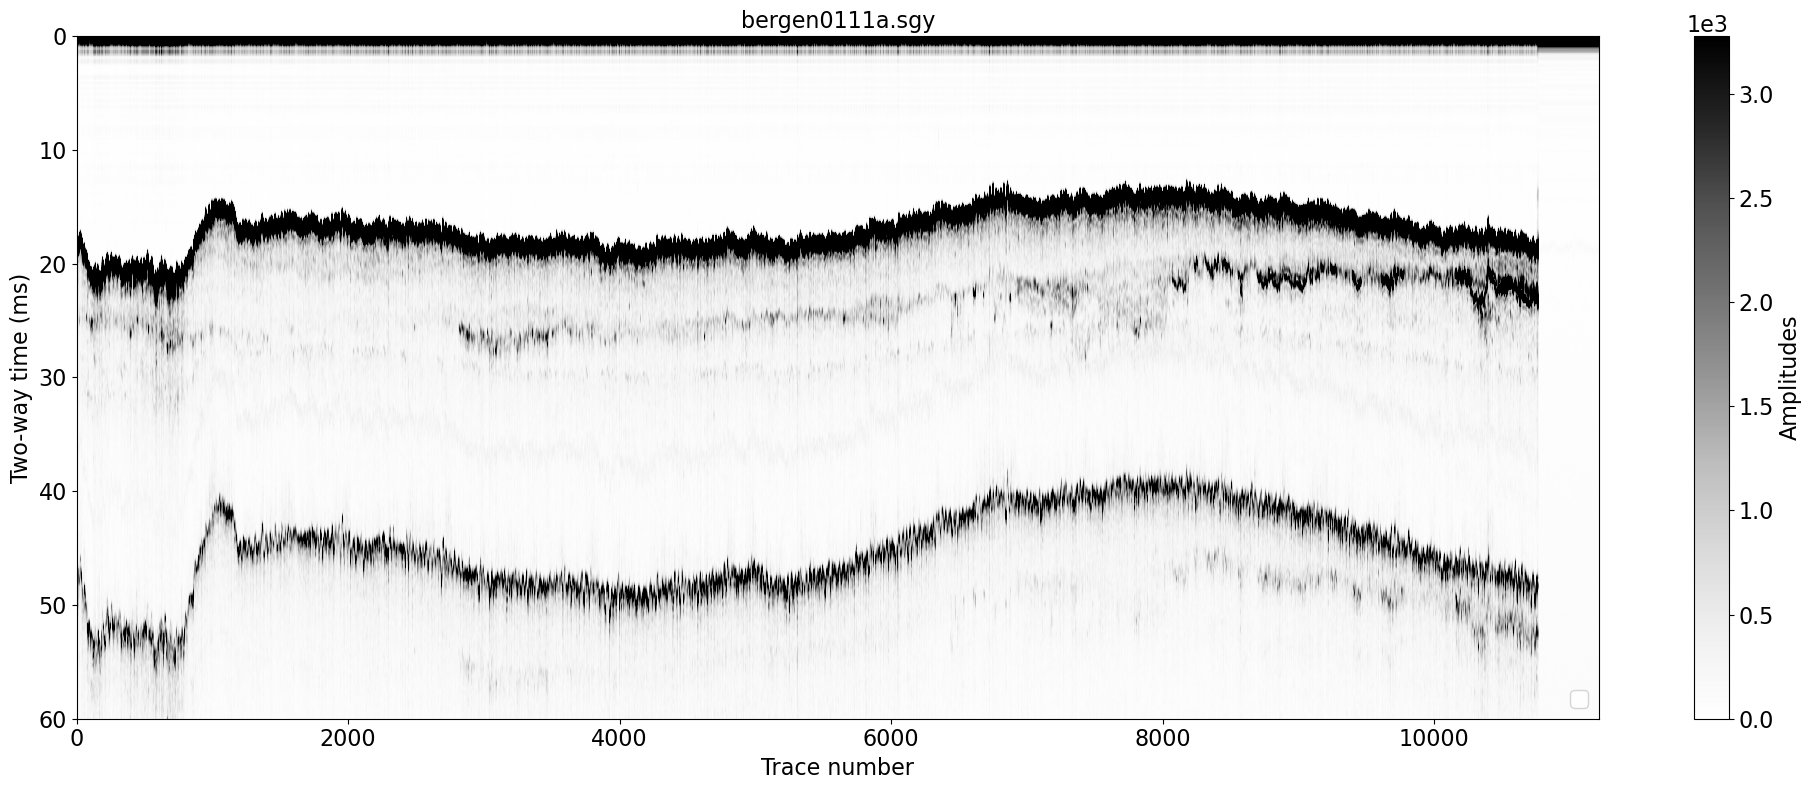

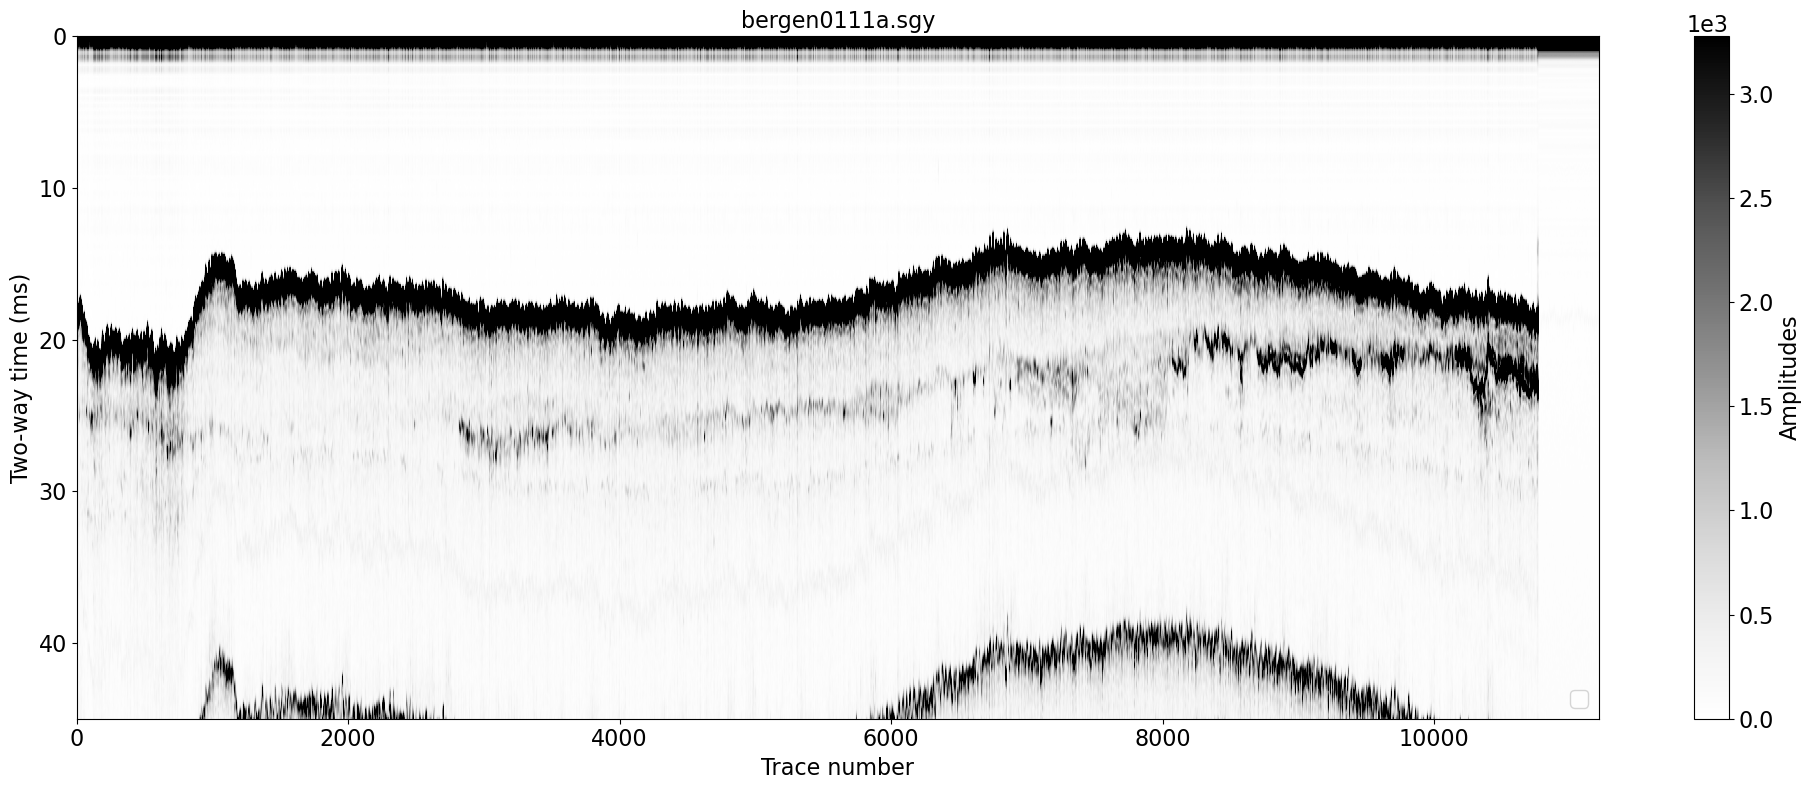

In [4]:
bergen.plot(clip=0.1)           # initial plot
bergen.set_record_length(45)    # cut the record length from 60 to 45 milliseconds
bergen.plot(clip=0.1)           # plot after cutting record length

### **Fix coordinates and coordinate transformation**
Now we inspect the coordinates that belong to the data traces and that are stored in the meta data of the seg-y data called 'trace headers'. In this example, the coordinates are in good shape, there are no outliers. Happy days!

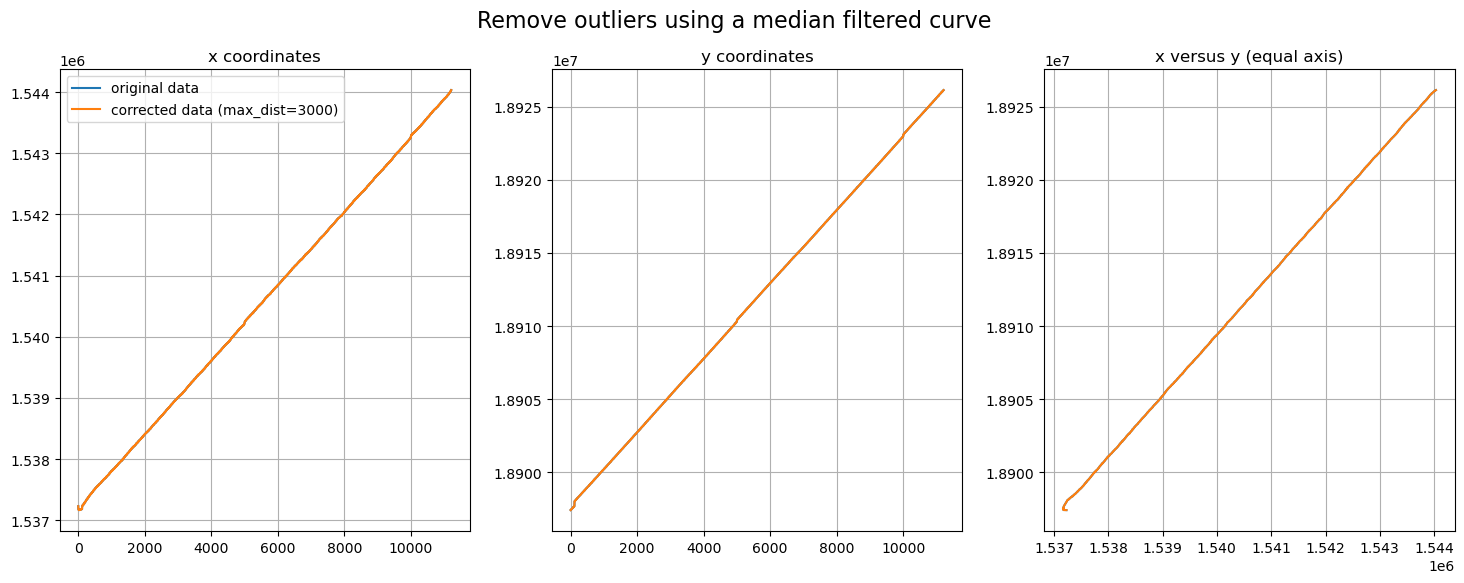

In [5]:
bergen.fix_navigation_median()

Now we perform a coordinate transformation on the meta data in the trace headers. Our input file has geographical coordinates (lattitude, longitude) in WGS 84 (epsg 4326) and we would like to transform these to projected coordinates (easting, northing) in WGS 84, UTM 31 N (epsg 32631).

In [6]:
bergen.set_crs(4326)
bergen.transform_coordinates(32631)

CRS set to EPSG:4326


### **Import bathymetric grid**
In the next step we will import an a ASCII (.asc) bathymetric grid of the same area where the seismic data was recorded. For all the coordinates in the meta data of the seg-y we will find the associated bathymetric depth using that grid.
- first we set the path to the batymetric grid and then refer to that as the first argument in the read_grid method
- then we have to set coordinate system of the seg-y, because we have just changed it to project WGS84 UTM 31 N (epsg 32631), we have to set that system!
- then we have to set the coordinate system of the asci grid, which in this case is in geographic WGS 84 (epsg 4326)
- as a last argument we put in the name we would like to give the output 'horizon'

In [7]:
grid_path = resource_folder / "bathy_clip_bergen0111a.asc"               # set the path of the grid, from which you would like to extract the horizon
bergen.read_grid(grid_path, 4326, horizon_name='bathy')              # import the depths of the grids at the coordinates of the segy data

bergen.x
bergen.bathy



array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

### **Seabed pick**
Now we will pick the seabed reflector in from the seismic data. This uses the obspy STA/LTA function that is used for determining onsets of earthquakes. There are several parameters, so we first print the docstring of the function to get more information. After this we can set the parameters appropriately. This can be done for any of the methods in this notebook.

Then we plot the data again and the bathymetric grid depths (converted to two-way travel time) and the seabed pick are plotted automatically. We set save_plot to True for later quality control.

In [8]:
help(bergen.get_seabed_pick)

Help on method get_seabed_pick in module deltaseis.tools.segy_editor:

get_seabed_pick(nsta, nlta, threshold, peak_threshold, pick_peaks=True, start_window=0, end_window=0, truncate=0) method of deltaseis.tools.segy_editor.Segy_edit instance
    Pick the seabed in the seismic sections

    Parameters
    ----------
    trigger_threshold : float
        Trigger threshold (amplitude ratio)
    sta : float
        Short-term average window (in milliseconds)
    lta : float
        Long-term average window (in milliseconds)



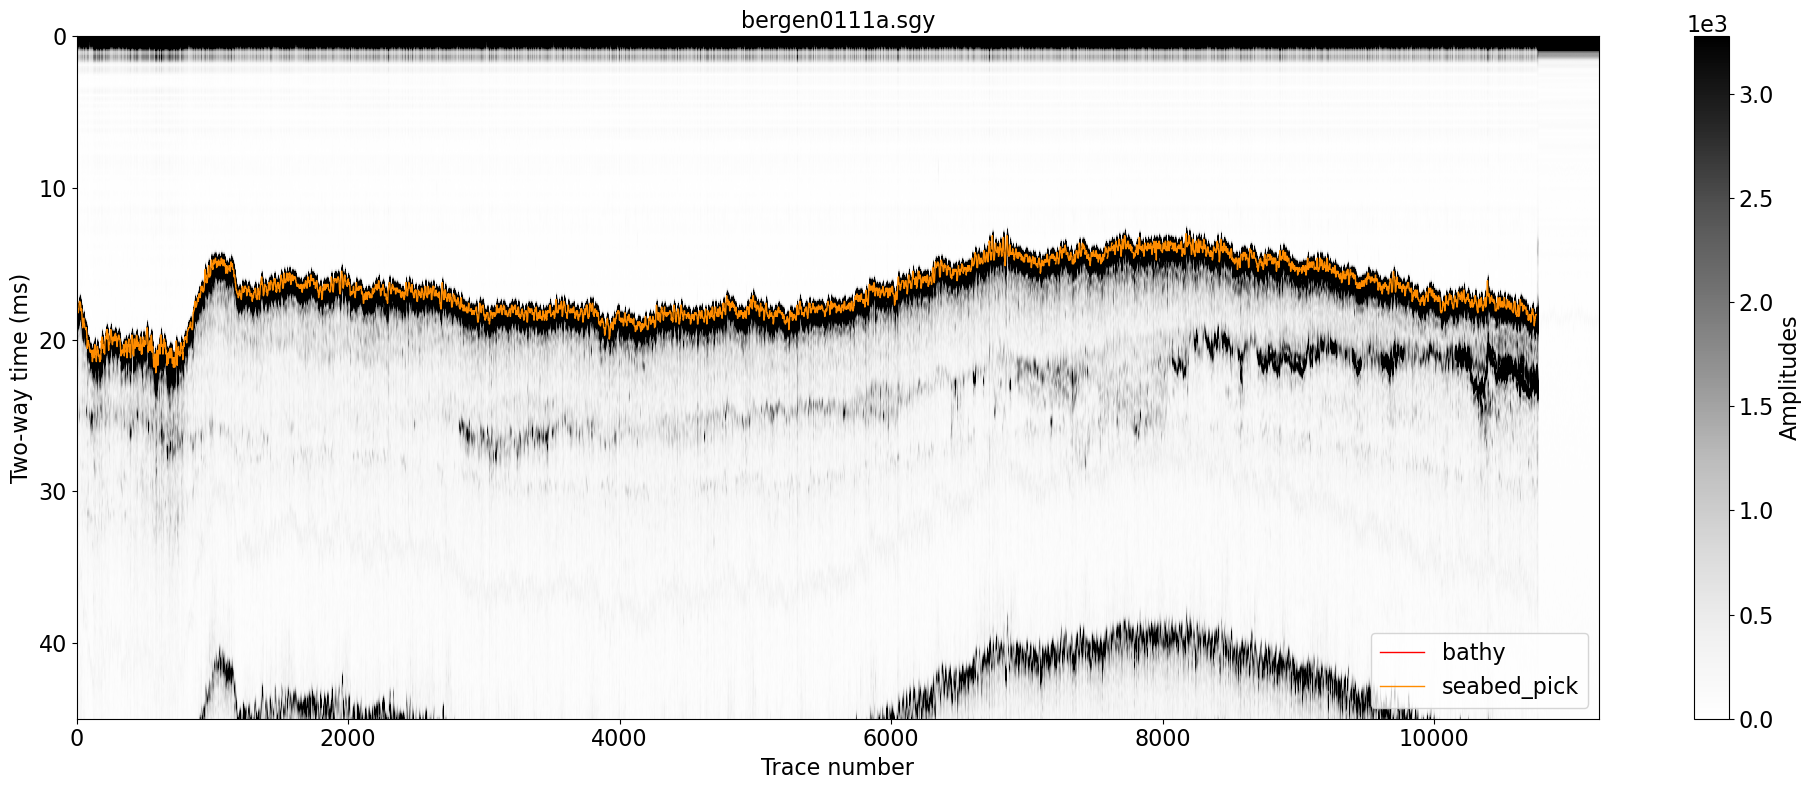

In [9]:
bergen.get_seabed_pick(10, 100, 9, 3, truncate=10) # clearly this method needs beter documentation!!!
bergen.plot(save_plot=True, clip=0.1)              # plot the data and save, clip the maximum amplitudes (this acts as a visual gain only)

### **Vertical corrections**
In the next two steps we calculate and apply corrections for heave of the ship recording the seismic data and corrections for tide changes during the recording.


##### For heave correction
- First we apply a savitsky-golay filter to the seabed pick so that it is smooths out the effect of heave (*warning*: this could also filter short wavelenght mega ripples)
- Then we calculate the difference between the original and the smoothed seabed pick
- The resulting difference is applied as vertical corrections to the data, which is now 'heave corrected'

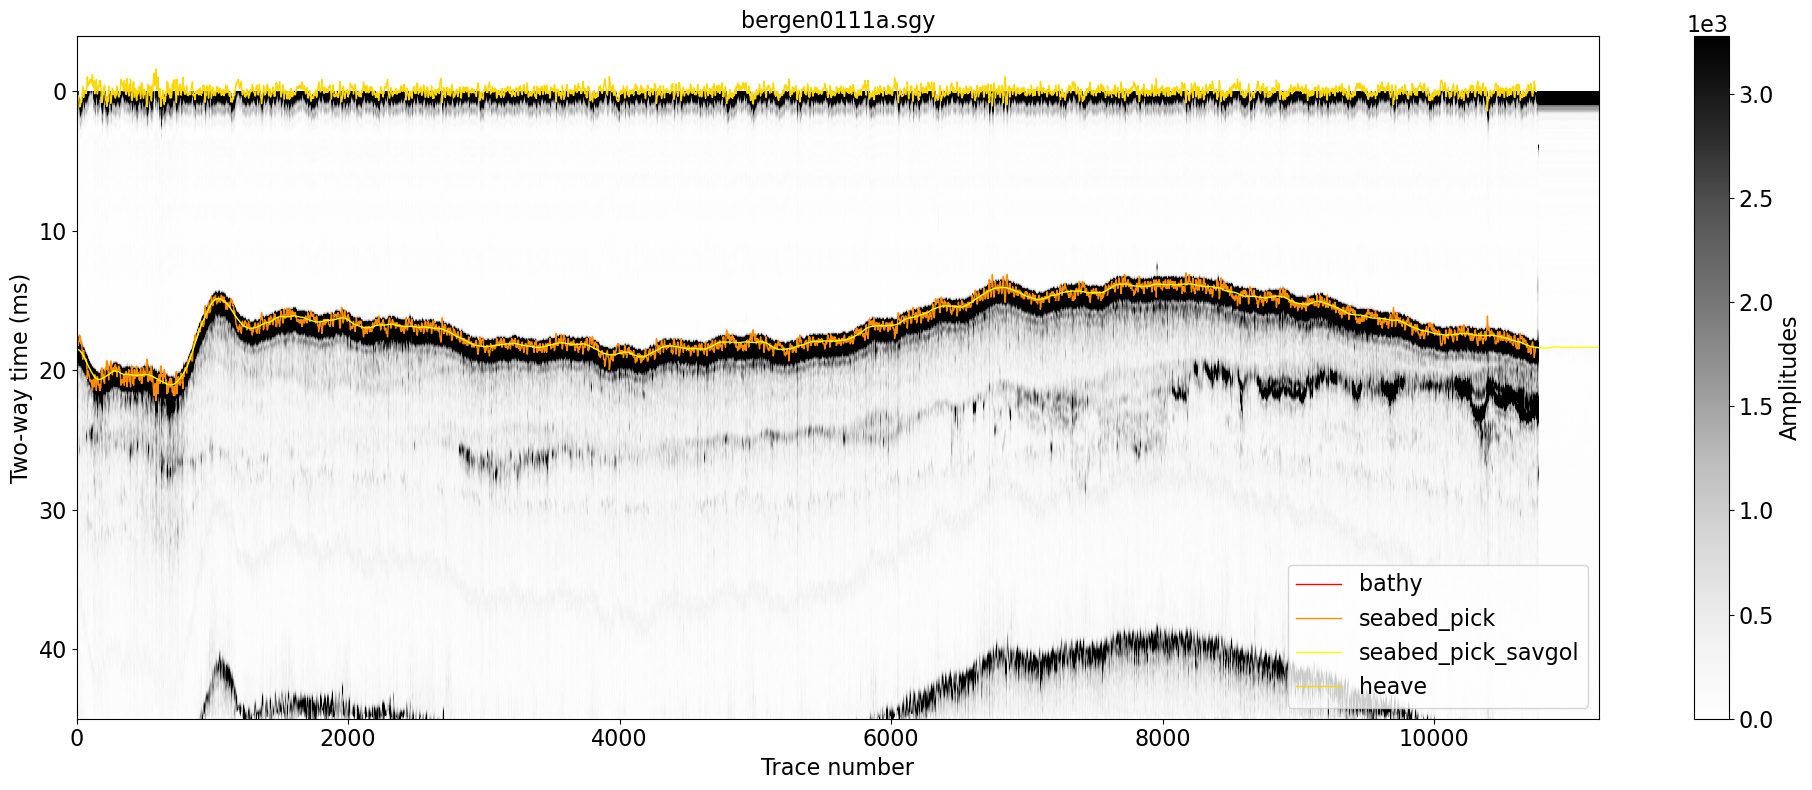

In [10]:
bergen.filter_horizon_savgol('seabed_pick', 'seabed_pick_savgol', 501, 4)
bergen.calculate_difference_horizon('seabed_pick_savgol', 'seabed_pick', difference_horizon_name = 'heave')
bergen.vertical_trace_corrections(bergen.heave)
bergen.plot(save_plot=True, clip=0.1)

##### For tide correction
- First we apply a savitsky-golay filter to the seabed pick so that it is smooths out the effect of heave (*warning*: this could also filter short wavelenght mega ripples)
- First we calculate the difference between the bathymetric grid and the seabed pick
- Then a very smooth trend through this resulting 'raw tide' is calculated
- The result is the actual tide effect and is applied as a vertical correction to the data, which is now 'tide corrected' 

Note 1: if we would apply the raw tide to the data, the seabed would fit exactly to the bathymetric grid which seems like the perfect correction. However, for reasons beyond the scope of this tutorial, the shape of the seabed pick and the bathymetry will never be identical and 'forcing' the seismic data onto it strongly distorts the signal and **greatly reduces its interpretability**

Note 2: the tide als includes vertical corrections for the changes in sensor depth that result from changes the recording vessels velocities and/or changes in sea currents.

In [11]:
bergen.calculate_difference_horizon('bathy', 'seabed_pick', difference_horizon_name ='tide_raw')
bergen.filter_horizon_savgol('tide_raw', 'tide', 2001, 2)
bergen.vertical_trace_corrections(bergen.tide)
bergen.plot(save_plot=True, clip=0.1)

IndexError: index 1 is out of bounds for axis 0 with size 0

The next step is to set some of the trace header meta data to industry standard, or user required values. This helps the seg-y to become more easily loadable in interpretation software.

In [ ]:
bergen.set_endian('big')                            # set file format to have big endian byte order
bergen.set_trace_number_in_field_record()           # set trace number in field record to 1 for single-channel data
bergen.renumber_shotpoints()                        # populate shotpoint numbers and set to unique values per trace
bergen.copy_source_coordinates_to_group()           # copy coordinates between coordinate trace headers
bergen.set_scalar(-1000)                            # set the scalar for the output file

The last step is to write the results to seg-y

In [ ]:
segy_outfile = segy_file.with_stem(segy_file.stem + "_TUTORIAL")    # set the path of the output seg-y file to be the same as input but with _TUTORIAL added to the name
bergen.write(segy_outfile)                                          # write the edits to seg-y

After the file is written, you can load the data for inspection using freeware [Seisee](https://seisee.software.informer.com/ "Download page Seisee"), or load it into dedicated interpretation software like Kingdom or Petrel.